#built on https://github.com/aub-mind/arabert 

In [1]:
#importing modules
import torch
device = torch.device("cuda")

import pandas as pd
import numpy as np
from typing import List
import copy
from tqdm import tqdm_notebook as tqdm
import random

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)

from arabert.preprocess import ArabertPreprocessor
from torch.utils.data import DataLoader, Dataset

from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

C:\Users\melsh\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#getting data
df=pd.read_csv("raw_data.csv")
df_train, df_test = train_test_split(df, test_size=.2, random_state=42)

In [4]:
#preprossing
model_name = 'aubmindlab/bert-base-arabertv02-twitter'
arabic_prep = ArabertPreprocessor(model_name,keep_emojis=False)

# df_train["Text"] = df_train["Text"].apply(lambda x: arabic_prep.preprocess(x))
# df_test["Text"] = df_test["Text"].apply(lambda x: arabic_prep.preprocess(x))  

In [5]:
#intiallizing the tokenizer
tok = AutoTokenizer.from_pretrained(model_name)

Training Sentence Lengths: 


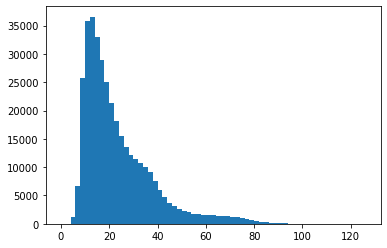

Testing Sentence Lengths: 


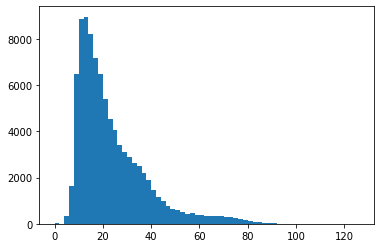

In [7]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in df_train["Text"].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in df_test["Text"].to_list()],bins=range(0,128,2))
plt.show()

In [6]:
#as there is no very long sequences we can use the whole sequence
max_len = 100

In [7]:
# create function to load the data
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
        super(ClassificationDataset).__init__()
        """
        Args:
        text (List[str]): List of the training text
        target (List[str]): List of the training labels
        tokenizer_name (str): The tokenizer name (same as model_name).
        max_len (int): Maximum sentence length
        label_map (Dict[str,int]): A dictionary that maps the class labels to integer
        """
        self.text = text
        self.target = target
        self.tokenizer_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len
        self.label_map = label_map
      

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())

        inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
        )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [8]:
label_map = { v:index for index, v in enumerate(df.dialect.unique()) }
print(label_map)

train_dataset = ClassificationDataset(
    df_train["Text"].to_list(),
    df_train["dialect"].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    df_test["Text"].to_list(),
    df_test["dialect"].to_list(),
    model_name,
    max_len,
    label_map
  )

{'IQ': 0, 'LY': 1, 'QA': 2, 'PL': 3, 'SY': 4, 'TN': 5, 'JO': 6, 'MA': 7, 'SA': 8, 'YE': 9, 'DZ': 10, 'EG': 11, 'LB': 12, 'KW': 13, 'OM': 14, 'SD': 15, 'AE': 16, 'BH': 17}


In [9]:
# Create a function that return a pretrained model ready to do classification
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [10]:
def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    print(classification_report(p.label_ids,preds))
    print(confusion_matrix(p.label_ids,preds))
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {       
    'macro_f1' : macro_f1,
    'accuracy': acc}

In [11]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

In [12]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'accuracy',
    greater_is_better = True,
    seed = 42
  )

set_seed(training_args.seed)

In [13]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [18]:
#start the training
trainer.train()

***** Running training *****
  Num examples = 366557
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 22910


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,1.317200,1.253321,0.571399,0.600022
2,1.107900,1.200425,0.596128,0.618354


***** Running Evaluation *****
  Num examples = 91640
  Batch size = 128


              precision    recall  f1-score   support

           0       0.65      0.65      0.65      3046
           1       0.75      0.71      0.73      7356
           2       0.56      0.55      0.55      6204
           3       0.56      0.63      0.59      8611
           4       0.51      0.41      0.46      3251
           5       0.71      0.50      0.58      1810
           6       0.59      0.31      0.40      5661
           7       0.83      0.62      0.71      2279
           8       0.44      0.59      0.50      5474
           9       0.60      0.28      0.38      1988
          10       0.65      0.55      0.60      3254
          11       0.75      0.91      0.82     11462
          12       0.61      0.77      0.68      5523
          13       0.50      0.67      0.57      8355
          14       0.46      0.45      0.45      3829
          15       0.79      0.66      0.72      2849
          16       0.53      0.40      0.46      5428
          17       0.48    

Saving model checkpoint to ./train\checkpoint-11455
Configuration saved in ./train\checkpoint-11455\config.json
Model weights saved in ./train\checkpoint-11455\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 91640
  Batch size = 128


              precision    recall  f1-score   support

           0       0.71      0.64      0.67      3046
           1       0.76      0.73      0.74      7356
           2       0.55      0.59      0.57      6204
           3       0.56      0.63      0.59      8611
           4       0.58      0.42      0.49      3251
           5       0.75      0.52      0.61      1810
           6       0.52      0.42      0.47      5661
           7       0.83      0.64      0.72      2279
           8       0.48      0.58      0.53      5474
           9       0.52      0.33      0.40      1988
          10       0.64      0.62      0.63      3254
          11       0.78      0.90      0.84     11462
          12       0.71      0.72      0.72      5523
          13       0.57      0.63      0.60      8355
          14       0.50      0.46      0.48      3829
          15       0.81      0.67      0.73      2849
          16       0.50      0.49      0.49      5428
          17       0.45    

Saving model checkpoint to ./train\checkpoint-22910
Configuration saved in ./train\checkpoint-22910\config.json
Model weights saved in ./train\checkpoint-22910\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train\checkpoint-22910 (score: 0.6183544303797468).


TrainOutput(global_step=22910, training_loss=1.2929645246941155, metrics={'train_runtime': 7107.515, 'train_samples_per_second': 103.146, 'train_steps_per_second': 3.223, 'total_flos': 3.76793180468856e+16, 'train_loss': 1.2929645246941155, 'epoch': 2.0})

In [21]:
#save the model
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir\config.json


{0: 'IQ', 1: 'LY', 2: 'QA', 3: 'PL', 4: 'SY', 5: 'TN', 6: 'JO', 7: 'MA', 8: 'SA', 9: 'YE', 10: 'DZ', 11: 'EG', 12: 'LB', 13: 'KW', 14: 'OM', 15: 'SD', 16: 'AE', 17: 'BH'}


Model weights saved in output_dir\pytorch_model.bin
tokenizer config file saved in output_dir\tokenizer_config.json
Special tokens file saved in output_dir\special_tokens_map.json


('output_dir\\tokenizer_config.json',
 'output_dir\\special_tokens_map.json',
 'output_dir\\vocab.txt',
 'output_dir\\added_tokens.json',
 'output_dir\\tokenizer.json')

## predict using the saved model

In [17]:
from transformers import pipeline

In [18]:
# initialize pipline
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=False)

loading configuration file output_dir\config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "IQ",
    "1": "LY",
    "2": "QA",
    "3": "PL",
    "4": "SY",
    "5": "TN",
    "6": "JO",
    "7": "MA",
    "8": "SA",
    "9": "YE",
    "10": "DZ",
    "11": "EG",
    "12": "LB",
    "13": "KW",
    "14": "OM",
    "15": "SD",
    "16": "AE",
    "17": "BH"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "AE": 16,
    "BH": 17,
    "DZ": 10,
    "EG": 11,
    "IQ": 0,
    "JO": 6,
    "KW": 13,
    "LB": 12,
    "LY": 1,
    "MA": 7,
    "OM": 14,
    "PL": 3,
    "QA": 2,
    "SA": 8,
    "SD": 15,
    "SY": 4,
    "TN": 5,
    "YE": 9
  },
  

In [22]:
texts=["مصر","زول"]
probs=pipe(texts)
response=[]
for i, row in enumerate(probs):
                row_pred = {}
                row_pred['text'] = texts[i]
                row_pred['predictions'] = row
                response.append(row_pred)

In [23]:
response

[{'text': 'مصر', 'predictions': {'label': 'EG', 'score': 0.49597689509391785}},
 {'text': 'زول', 'predictions': {'label': 'SD', 'score': 0.888106644153595}}]